In [1]:
import math
import torch
import torch.nn as nn
import hess
from hess.nets import MaskedNet
from torch.nn import Module, init
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import numpy as np
from hess import utils
import matplotlib.pyplot as plt

## Now actually trying to build masked nets ##

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
X, Y = twospirals(500, noise=1.3)
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

In [4]:
model = hess.nets.MaskedNet(train_x, train_y, bias=True, n_hidden=5, pct_keep=0.9)

In [5]:
loss_func=nn.MSELoss()
optim=torch.optim.Adam
lr=0.01
iters=1000

optimizer=optim(model.parameters(), lr=lr)


optimizer.zero_grad()
outputs = model(train_x)

loss=loss_func(outputs,train_y)

In [6]:
loss.backward()

## Compute Hessian

In [7]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [8]:
hessian = torch.zeros(n_par, n_par)
for pp in range(n_par):
    base_vec = torch.zeros(n_par).unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model.parameters(),
                            net=model,
                            criterion=torch.nn.BCEWithLogitsLoss(),
                            inputs=train_x, targets=train_y)
    if pp == 0:
        output = utils.gradtensor_to_tensor(model, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    
#     print(pp)
    hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()

In [9]:
def get_mask(net):
    mask_list = []
    for lyr in net.sequential:
        if isinstance(lyr, hess.nets.MaskedLayer):
            mask_list.append(lyr.mask)
            
    return hess.utils.flatten(mask_list)

In [10]:
mask = get_mask(model)

In [11]:
keepers = np.array(np.where(mask == 1))[0]
sub_hess = hessian[np.ix_(keepers, keepers)]

In [12]:
e_val, e_vec = np.linalg.eig(hessian.detach())
idx = np.abs(e_val).argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:, idx].real)

### Let's take a peaky at those loss surfaces

In [13]:
import hess.loss_surfaces as loss_surfaces

In [14]:
nvec = 50
basis = e_vec[:, -nvec:]
loss_surf = loss_surfaces.get_loss_surface(basis, model,
                                         train_x, train_y,
                                         loss=torch.nn.BCEWithLogitsLoss(),
                                         rng=1., n_pts=50, scale=1.,
                                         use_cuda=False)

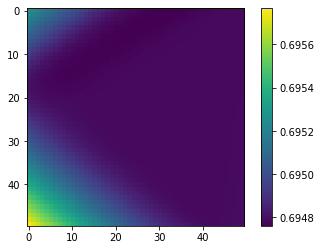

In [15]:
plt.imshow(loss_surf.detach())
plt.colorbar()

## Train

In [16]:
loss_func=nn.MSELoss()
optim=torch.optim.Adam
lr=0.01
iters=1000

optimizer=optim(model.parameters(), lr=lr)

for step in range(iters):
    optimizer.zero_grad()
    outputs = model(train_x)

    loss=loss_func(outputs,train_y)
    print(loss)
    loss.backward()
    optimizer.step()

tensor(0.6717, grad_fn=<MseLossBackward>)
tensor(0.6169, grad_fn=<MseLossBackward>)
tensor(0.5716, grad_fn=<MseLossBackward>)
tensor(0.5290, grad_fn=<MseLossBackward>)
tensor(0.4885, grad_fn=<MseLossBackward>)
tensor(0.4509, grad_fn=<MseLossBackward>)
tensor(0.4141, grad_fn=<MseLossBackward>)
tensor(0.3777, grad_fn=<MseLossBackward>)
tensor(0.3474, grad_fn=<MseLossBackward>)
tensor(0.3299, grad_fn=<MseLossBackward>)
tensor(0.3246, grad_fn=<MseLossBackward>)
tensor(0.3171, grad_fn=<MseLossBackward>)
tensor(0.3024, grad_fn=<MseLossBackward>)
tensor(0.2847, grad_fn=<MseLossBackward>)
tensor(0.2703, grad_fn=<MseLossBackward>)
tensor(0.2599, grad_fn=<MseLossBackward>)
tensor(0.2535, grad_fn=<MseLossBackward>)
tensor(0.2496, grad_fn=<MseLossBackward>)
tensor(0.2465, grad_fn=<MseLossBackward>)
tensor(0.2428, grad_fn=<MseLossBackward>)
tensor(0.2383, grad_fn=<MseLossBackward>)
tensor(0.2345, grad_fn=<MseLossBackward>)
tensor(0.2324, grad_fn=<MseLossBackward>)
tensor(0.2317, grad_fn=<MseLossBac

tensor(0.0578, grad_fn=<MseLossBackward>)
tensor(0.0579, grad_fn=<MseLossBackward>)
tensor(0.0579, grad_fn=<MseLossBackward>)
tensor(0.0576, grad_fn=<MseLossBackward>)
tensor(0.0575, grad_fn=<MseLossBackward>)
tensor(0.0574, grad_fn=<MseLossBackward>)
tensor(0.0571, grad_fn=<MseLossBackward>)
tensor(0.0571, grad_fn=<MseLossBackward>)
tensor(0.0569, grad_fn=<MseLossBackward>)
tensor(0.0568, grad_fn=<MseLossBackward>)
tensor(0.0568, grad_fn=<MseLossBackward>)
tensor(0.0567, grad_fn=<MseLossBackward>)
tensor(0.0572, grad_fn=<MseLossBackward>)
tensor(0.0568, grad_fn=<MseLossBackward>)
tensor(0.0563, grad_fn=<MseLossBackward>)
tensor(0.0562, grad_fn=<MseLossBackward>)
tensor(0.0565, grad_fn=<MseLossBackward>)
tensor(0.0566, grad_fn=<MseLossBackward>)
tensor(0.0563, grad_fn=<MseLossBackward>)
tensor(0.0560, grad_fn=<MseLossBackward>)
tensor(0.0558, grad_fn=<MseLossBackward>)
tensor(0.0561, grad_fn=<MseLossBackward>)
tensor(0.0559, grad_fn=<MseLossBackward>)
tensor(0.0557, grad_fn=<MseLossBac

tensor(0.0486, grad_fn=<MseLossBackward>)
tensor(0.0476, grad_fn=<MseLossBackward>)
tensor(0.0473, grad_fn=<MseLossBackward>)
tensor(0.0474, grad_fn=<MseLossBackward>)
tensor(0.0474, grad_fn=<MseLossBackward>)
tensor(0.0472, grad_fn=<MseLossBackward>)
tensor(0.0471, grad_fn=<MseLossBackward>)
tensor(0.0472, grad_fn=<MseLossBackward>)
tensor(0.0471, grad_fn=<MseLossBackward>)
tensor(0.0470, grad_fn=<MseLossBackward>)
tensor(0.0471, grad_fn=<MseLossBackward>)
tensor(0.0482, grad_fn=<MseLossBackward>)
tensor(0.0490, grad_fn=<MseLossBackward>)
tensor(0.0477, grad_fn=<MseLossBackward>)
tensor(0.0486, grad_fn=<MseLossBackward>)
tensor(0.0483, grad_fn=<MseLossBackward>)
tensor(0.0485, grad_fn=<MseLossBackward>)
tensor(0.0482, grad_fn=<MseLossBackward>)
tensor(0.0479, grad_fn=<MseLossBackward>)
tensor(0.0474, grad_fn=<MseLossBackward>)
tensor(0.0479, grad_fn=<MseLossBackward>)
tensor(0.0471, grad_fn=<MseLossBackward>)
tensor(0.0476, grad_fn=<MseLossBackward>)
tensor(0.0474, grad_fn=<MseLossBac

tensor(0.0428, grad_fn=<MseLossBackward>)
tensor(0.0419, grad_fn=<MseLossBackward>)
tensor(0.0424, grad_fn=<MseLossBackward>)
tensor(0.0425, grad_fn=<MseLossBackward>)
tensor(0.0421, grad_fn=<MseLossBackward>)
tensor(0.0423, grad_fn=<MseLossBackward>)
tensor(0.0422, grad_fn=<MseLossBackward>)
tensor(0.0421, grad_fn=<MseLossBackward>)
tensor(0.0417, grad_fn=<MseLossBackward>)
tensor(0.0424, grad_fn=<MseLossBackward>)
tensor(0.0417, grad_fn=<MseLossBackward>)
tensor(0.0418, grad_fn=<MseLossBackward>)
tensor(0.0417, grad_fn=<MseLossBackward>)
tensor(0.0415, grad_fn=<MseLossBackward>)
tensor(0.0416, grad_fn=<MseLossBackward>)
tensor(0.0414, grad_fn=<MseLossBackward>)
tensor(0.0412, grad_fn=<MseLossBackward>)
tensor(0.0413, grad_fn=<MseLossBackward>)
tensor(0.0414, grad_fn=<MseLossBackward>)
tensor(0.0413, grad_fn=<MseLossBackward>)
tensor(0.0412, grad_fn=<MseLossBackward>)
tensor(0.0415, grad_fn=<MseLossBackward>)
tensor(0.0416, grad_fn=<MseLossBackward>)
tensor(0.0414, grad_fn=<MseLossBac

tensor(0.0392, grad_fn=<MseLossBackward>)
tensor(0.0395, grad_fn=<MseLossBackward>)
tensor(0.0401, grad_fn=<MseLossBackward>)
tensor(0.0396, grad_fn=<MseLossBackward>)
tensor(0.0398, grad_fn=<MseLossBackward>)
tensor(0.0395, grad_fn=<MseLossBackward>)
tensor(0.0397, grad_fn=<MseLossBackward>)
tensor(0.0392, grad_fn=<MseLossBackward>)
tensor(0.0394, grad_fn=<MseLossBackward>)
tensor(0.0390, grad_fn=<MseLossBackward>)
tensor(0.0394, grad_fn=<MseLossBackward>)
tensor(0.0393, grad_fn=<MseLossBackward>)
tensor(0.0392, grad_fn=<MseLossBackward>)
tensor(0.0392, grad_fn=<MseLossBackward>)
tensor(0.0390, grad_fn=<MseLossBackward>)
tensor(0.0390, grad_fn=<MseLossBackward>)
tensor(0.0393, grad_fn=<MseLossBackward>)
tensor(0.0395, grad_fn=<MseLossBackward>)
tensor(0.0390, grad_fn=<MseLossBackward>)
tensor(0.0394, grad_fn=<MseLossBackward>)
tensor(0.0404, grad_fn=<MseLossBackward>)
tensor(0.0395, grad_fn=<MseLossBackward>)
tensor(0.0390, grad_fn=<MseLossBackward>)
tensor(0.0391, grad_fn=<MseLossBac

In [17]:
model.eval()

MaskedNet(
  (sequential): Sequential(
    (0): MaskedLayer(iln_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): MaskedLayer(iln_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): MaskedLayer(iln_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): MaskedLayer(iln_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): MaskedLayer(iln_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): MaskedLayer(iln_features=10, out_features=1, bias=True)
  )
)

In [18]:
hessian = torch.zeros(n_par, n_par)
for pp in range(n_par):
    base_vec = torch.zeros(n_par).unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model.parameters(),
                            net=model,
                            criterion=torch.nn.BCEWithLogitsLoss(),
                            inputs=train_x, targets=train_y)
    if pp == 0:
        output = utils.gradtensor_to_tensor(model, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    
#     print(pp)
    hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()

In [19]:
mask = get_mask(model)

In [20]:
keepers = np.array(np.where(mask == 1))[0]
sub_hess = hessian[np.ix_(keepers, keepers)]

e_val, e_vec = np.linalg.eig(sub_hess.detach())
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:, idx].real)

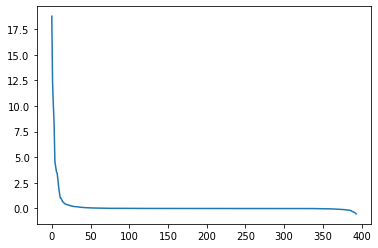

In [21]:
plt.plot(e_val)

## Plot Predictions

In [22]:
buffer = 0.3
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [23]:
pred = torch.sigmoid(model(in_grid).squeeze().cpu()).detach().numpy().reshape(xx.shape)

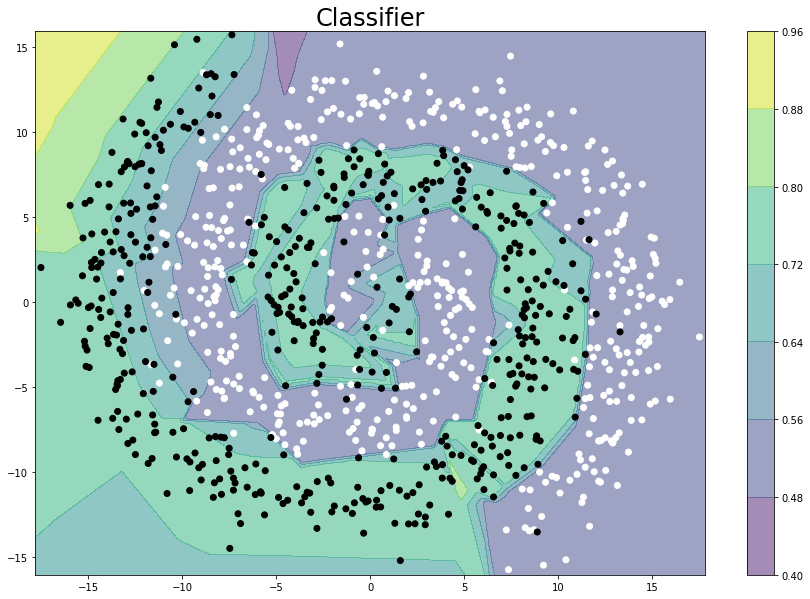

In [24]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, pred, alpha=0.5)
# plt.title("Temp Scaled", fontsize=24)
plt.title("Classifier", fontsize=24)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)
plt.savefig("./two-spiral-classifier.pdf", bbox_inches="tight")